# Q-learning agent with epsilon-greedy and experience replay
Team member: Phan Nhat Huy, Vu Hong Phuc, Tran Quang Thanh.

### Utility of Policy
With a policy $\pi$, it can generate an action based on current state $a_{t+1} = \pi(s_t)$.To evaluate the "value" of a state with policy $\pi$ we define utility of a policy at state $s_0$ is:
\begin{equation}
    U^{\pi}\left(\mathrm{s}_{0}\right)=E\left[\sum_{t=0}^{\infty} \gamma^{t} R\left(s_{t}, \pi\left(s_{t}\right), s_{t+1}\right)\right]
\end{equation}

### Optimal policy

An optimal policy $\pi^{*}(s)$ is the policy from state $s$  that maximizes the utility at that state for any policy $\pi(s)$:
\begin{equation}
    \pi^{*}(s) = \arg \max U^{\pi}(s)
\end{equation}

### Q-function

\begin{equation}
    U^{*}(s)=\max _{a} Q^{*}(s, a)
\end{equation}

### Value iteration
By using recursive update of utility function of state, we can estimate that value:
\begin{equation}
    U_{\mathrm{k}+1}(\mathrm{~s}) \leftarrow \max _{\mathrm{a}} \sum_{s^{\prime}} P\left(\mathrm{~s}^{\prime} \mid \mathrm{a}, \mathrm{s}\right)\left[R\left(\mathrm{~s}, \mathrm{a}, \mathrm{s}^{\prime}\right)+\gamma \mathrm{U}_{\mathrm{k}}\left(\mathrm{s}^{\prime}\right)\right]    
\end{equation}

### Q learning

Q-learning is a model-free reinforcement learning algorithm for determining the worth of a certain action in a given state. It can handle problems with stochastic transitions and rewards without requiring adaptations and does not require a model of the environment (thus "model-free").
Q-learning provides an optimal policy for a Markov decision process (MDP) by maximizing the anticipated value of the total reward across any and all successive steps, beginning from the present state.
\begin{equation}
    Q_{t+1}\left(s_{t}, a_{t}\right)=Q_{t}\left(s_{t}, a_{t}\right)+\alpha\left(R_{t+1}+\gamma \max _{a} Q_{t}\left(s_{t+1}, a\right)-Q_{t}\left(s_{t}, a_{t}\right)\right)
\end{equation}

# Documentation

## QLearningAgent
```python
class QLearningAgent:

    def __init__(self, mdp, epsilon_greedy=False,experience_replay=False, Ne=None, Rplus=None, alpha=None, 
                no_of_episodes=5000, threshold=500, B = 30, K = 500, M = 5000):
```

#### Option A
$R$ is the constant penalty for moving

#### Option B
Set $experience\_replay = True$ to enable experience replay

$M$, $B$, $K$ respectively control the memory buffer, batch size, and the episode to start replay trial in experience replay (Option B)

#### Option C
Set $epsilon\_greedy = True$ to enable epsilon greedy

$\epsilon$ is the probability of exploration.

Q agent would choose a random action with probability $\epsilon$, and choose action that maximize $\max _{a} Q_{t}\left(s_{t+1}, a\right)$ with probability $1 - \epsilon$

$\epsilon$ is $1$ at the first stage and reduce by $\frac{1}{no\_of\_episodes}$ after each episode (See $no\_of\_episodes$ below).

#### Option D
$gamma$ ($\gamma$) is the discount factor (Option D)


#### Temporal difference learning

$alpha\_num$ is numerator of $alpha$ ($\alpha$) in temporal difference learning (See page 853 in AIMA book)

\begin{equation}
    \alpha = \frac{alpha\_num}{alpha\_num - 1 + n}
\end{equation}

Where $n$ is the number of time the agent reaches state $(s, a)$ so far

As $n$ increase, $\alpha$ would converge to $0$

#### Exploration function

$Ne$ and $Rplus$ are the same as in aima's original implementation (page 850 in AIMA book)

$$
    \mathrm{f}(u,n) = 
    \begin{cases}
    R^{+} & \text{if } n < N_e\\
    u & \text{otherwise }
    \end{cases}
$$

They will control the exploration function in case $epsilon\_greedy = False$


### Number of episodes

$no\_of\_episodes$ controls number of episodes to run Q learning

$threshold$ is the maximum number of steps that Q agent can take in an episode

Set $threshold$ to control avoid cases when agent enters infinite loop and never reaches terminal state

### Reimplement Q function

AIMA's code considers the utility at terminal state to be the value of the terminal state

Meaning in AIMA's code, utility also counts in reward at current state, which is not similar to the textbook's definition.

Therefore, we changed the Q function for value iteration algorithm and Q learning. Our modified Q function is the discounted sum of future rewards (same as in AIMA book). 


In [1]:
from reinforcement_learning4e import *
from mdp4e import GridMDP
from mdp4e import value_iteration

### Define constants

In [2]:
R = -0.3 #[-0.01, -0.3, -0.6]
gamma = 0.9 #[0.80, 0.85, 0.9, 0.98, 1]
no_of_episodes = 5000 #[1000, 2000, 5000, 10000]
threshold = 500 #[100, 500, 1000]
M = 5000 #[2000, 5000, 10000]
B = 30 #[10, 30, 50]
K = 100 #[0, 100, 500, 10000]
alpha_num = 200 #[60, 200, 500, 1000]
Ne = 100 #[60,100, 200, 300]
Rplus = 5 #[0, 2, 5, 20]

In [3]:
alpha = lambda n: alpha_num /(alpha_num-1+n)

## Training and Plotting utilities

```python
    def graph_utility_estimates_q_learning(agent_program, mdp, no_of_episodes, states_to_graph):

```

A function to train an Q agent ($agent\_program$) on an environment ($mdp$) 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def graph_utility_estimates_q_learning(agent_program, mdp, no_of_episodes, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_episodes+1):
        run_single_trial(agent_program, mdp)
        U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison.
        for state_action, value in agent_program.Q.items():
            state, action = state_action
            if U[state] < value:
                        U[state] = value
        for state in states_to_graph:
            graphs[state].append((iteration, U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.annotate('Value iteration output: {:.4f}'.format(value_iteration(mdp).get((0,0))),
            xy = (0.5, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    plt.annotate('Q learning output: {:.4f}'.format(U.get((0,0))),
            xy = (1.0, -0.2),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
#     plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

## Option A Constant penalty for each moves

Berkley's original implementation of Q learning yields suboptimal policies for certain value of $R$

Wrong policies when penalty is too low (e.g $-0.01, -0.1$) 


In [5]:
R = -0.01
R_low_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)
R = -0.1
R_medium_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)

R = -0.3
R_high_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)

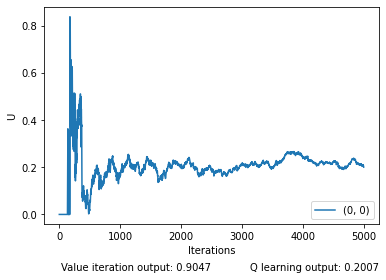

In [6]:
q_agent_R_low = QLearningAgent(mdp=R_low_environment,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes)
graph_utility_estimates_q_learning(q_agent_R_low, R_low_environment, no_of_episodes, [(0,0)])

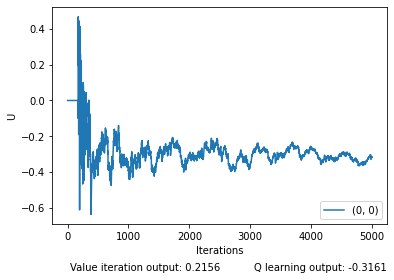

In [7]:
q_agent_R_medium = QLearningAgent(mdp=R_medium_environment,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes)
graph_utility_estimates_q_learning(q_agent_R_medium, R_medium_environment, no_of_episodes, [(0,0)])

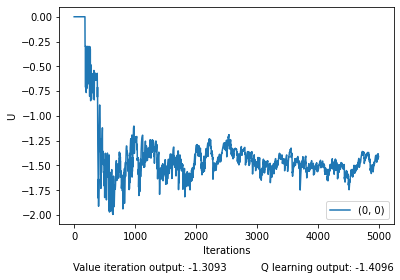

In [8]:
q_agent_R_high = QLearningAgent(mdp=R_high_environment,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes)
graph_utility_estimates_q_learning(q_agent_R_high, R_high_environment, no_of_episodes, [(0,0)])

## Option B: Experience Replay

Q learning with experience replay learns correct policies for low $R = -0.1$ 

In [9]:
R = -0.1
R_standard_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)

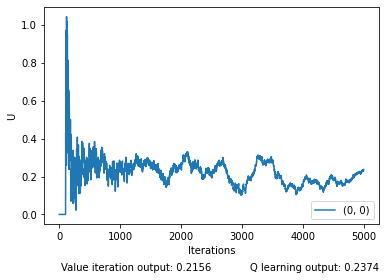

In [10]:
q_agent_experience_replay = QLearningAgent(mdp=R_standard_environment,experience_replay=True,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes,
                        B = B, M = M, K = K)
graph_utility_estimates_q_learning(q_agent_experience_replay, R_standard_environment, no_of_episodes, [(0,0)])

## Option C Epsilon-greedy

Q learning with epsilon-greedy performs even better than experience replay

Q learning with both epsilon-greedy and experience-replay also perform well. Generally, the algorithm still converges to correct utilities

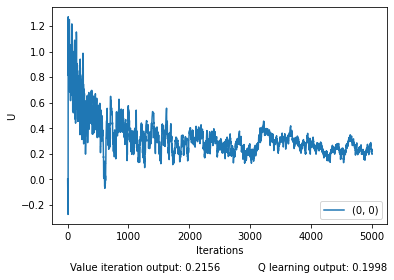

In [11]:
q_agent_epsilon_greedy = QLearningAgent(mdp=R_standard_environment,epsilon_greedy=True,
                        alpha=alpha,threshold=threshold,
                        no_of_episodes=no_of_episodes)
graph_utility_estimates_q_learning(q_agent_epsilon_greedy, R_standard_environment, no_of_episodes, [(0,0)])

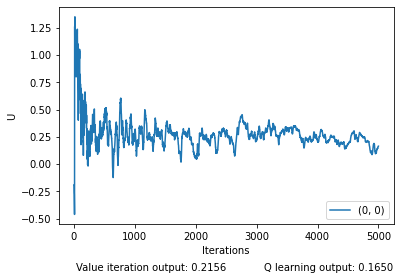

In [12]:
q_agent_all = QLearningAgent(mdp=R_standard_environment,epsilon_greedy=True,experience_replay=True,
                        alpha=alpha,threshold=threshold,
                        no_of_episodes=no_of_episodes,
                        B = B, M = M, K = K)
graph_utility_estimates_q_learning(q_agent_all, R_standard_environment, no_of_episodes, [(0,0)])

## Option D gamma

Q learning with experience replay and epsilon greedy can adapt to different values of discount factor $gamma$

In [13]:
R = -0.1

gamma = 0.85
gamma_low_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)
gamma = 0.9
gamma_medium_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)

gamma = 0.98
gamma_high_environment = GridMDP([[R, R, R, R, R, R, R, 10],
                           [R, R, -1, R, R, R, R, R],
                           [R, -1, -10, -1, R, R, R, -1],
                           [R, R, -1, R, None, None, None, -10],
                           [-1, R, R, R, R, -1, R, -1],
                           [-10, -1, R, R, -1, -10, -1, R],
                           [-1, R, R, R, R, -1, R, R],
                           [R, R, R, R, R, R, R, R]],
                          terminals=[(7, 7)],gamma = gamma)

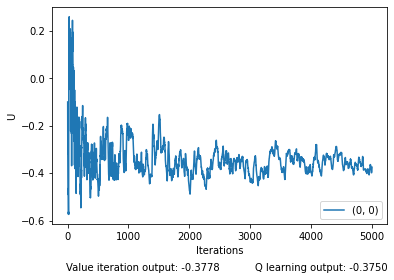

In [14]:
q_agent_gamma_low = QLearningAgent(mdp=gamma_low_environment,epsilon_greedy=True,experience_replay=True,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes,
                        B = B, M = M, K = K)
graph_utility_estimates_q_learning(q_agent_gamma_low, gamma_low_environment, no_of_episodes, [(0,0)])

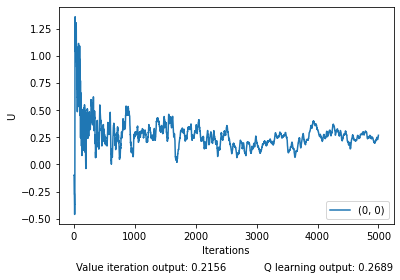

In [15]:
q_agent_gamma_medium = QLearningAgent(mdp=gamma_medium_environment,epsilon_greedy=True,experience_replay=True,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes,
                        B = B, M = M, K = K)
graph_utility_estimates_q_learning(q_agent_gamma_medium, gamma_medium_environment, no_of_episodes, [(0,0)])

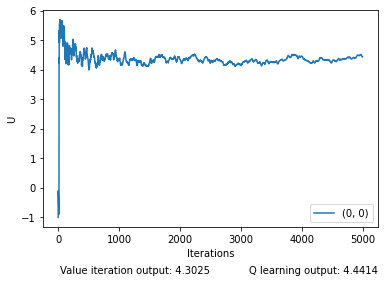

In [16]:
q_agent_gamma_high = QLearningAgent(mdp=gamma_high_environment,epsilon_greedy=True,experience_replay=True,
                        alpha=alpha,threshold=threshold,
                        Ne=Ne,Rplus=Rplus,no_of_episodes=no_of_episodes,
                                    B = B, M = M, K = K)
graph_utility_estimates_q_learning(q_agent_gamma_high, gamma_high_environment, no_of_episodes, [(0,0)])